# Volatility basket strategy

- Modified `32-vol-basket-strategy-vol-filter` 
- Use volatility as a ranking 
- Use Sharpe as filter criteria

# Set up

Set up Trading Strategy data client.


In [93]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [94]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "29-vol-basket-strategy-4h-exp-searched"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 10  # How many assets our basket can hold once
    allocation = 0.99  # Allocate all cash to volatile pairs
    min_rebalance_trade_threshold_pct = 0.10  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 10  # Don't make buys less than this amount
    min_volatility_threshold = 0.02  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.25 # How large % can one asset be in a portfolio once
    min_signal_threshold = 1.0  # How large signal we need to make a trade

    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    min_volume = 200_000   # USD
    min_liquidity = 200_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 11, 6)
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [95]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import filter_scams


#: Assets used in routing and buy-and-hold benchmark values for our strategy, but not traded by this strategy.
SUPPORTING_PAIRS = [
    (ChainId.ethereum, "uniswap-v3", "WBTC", "USDT", 0.0005),
    (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005),
    (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  # TODO: Needed until we have universal routing
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",  # USDC
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    print("Universe is (including benchmark pairs):")
    for idx, pair in enumerate(strategy_universe.iterate_pairs()):
        benchmark = pair.other_data.get("benchmark")
        print(f"   {idx + 1}. pair #{pair_id}: {pair.base.token_symbol} - {pair.quote.token_symbol} ({pair.exchange_name}), benchmark={'benchmark/routed' if benchmark else 'traded'}")

    return strategy_universe


# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 1480 tokens>
Total 72 pairs to trade on ethereum for categories {'Meme'}
After scam filter we have 63 pairs
Scammy pair TRUMP - WETH, risk score 0.0, pool 0x56bc8f3293f53825c9fbd6ddfe0cafefa82820d0, token 0x6aa56e1d98b3805921c170eb4b3fe7d4fda6d89b
Scammy pair BabyDoge - WETH, risk score 0.0, pool 0x9f2ebe69a86c079f3d4c3b94a11932b676b72f74, token 0xac57de9c1a09fec648e93eb98875b212db0d460b
Scammy pair Bonk - WETH, risk score 20.0, pool 0x403b1b747b1efb309070436c9ac99bf476f299ea, token 0x1151cb3d861920e07a38e03eead12c32178567f6
Scammy pair PEOPLE - WETH, risk score 25.0, pool 0x83abecf7204d5afc1bea5df734f085f2535a9976, token 0x7a58c0be72be218b41c608b7fe7c5bb630736c71
Scammy pair Puff - WETH, risk score 25.0, pool 0x0275885d271c9e5ae7d4aa15ae6c1bcb7e5ae2b8, token 0x31b6100f5f4466e6daeb1edb2f2ce6e548cf8938
Scammy pair VOLT - WETH, risk score 25.0, pool 0x96aa22baedc5a605357e0b9ae20ab6b10a472e03, token 0x7f792db54b0e580cdc755178443f0430cf799aca
Sc

Loading TVL/liquidity data for 63 pairs:   0%|          | 0/63 [00:00<?, ?it/s]

Universe is (including benchmark pairs):
   1. pair #1: WETH - USDC (uniswap-v3), benchmark=benchmark/routed
   2. pair #1: SPX - WETH (uniswap-v2), benchmark=traded
   3. pair #1: WBTC - USDT (uniswap-v3), benchmark=benchmark/routed
   4. pair #1: BITCOIN - WETH (uniswap-v2), benchmark=traded
   5. pair #1: Mog - WETH (uniswap-v2), benchmark=traded
   6. pair #1: Neiro - WETH (uniswap-v2), benchmark=traded
   7. pair #1: DOGE - WETH (uniswap-v2), benchmark=traded
   8. pair #1: MSTR - WETH (uniswap-v2), benchmark=traded
   9. pair #1: MAGA - WETH (uniswap-v2), benchmark=traded
   10. pair #1: APU - WETH (uniswap-v2), benchmark=traded
   11. pair #1: MOODENG - WETH (uniswap-v2), benchmark=traded
   12. pair #1: PEPE - WETH (uniswap-v2), benchmark=traded
   13. pair #1: NEIRO - WETH (uniswap-v3), benchmark=traded
   14. pair #1: HOPPY - WETH (uniswap-v2), benchmark=traded
   15. pair #1: KLAUS - WETH (uniswap-v2), benchmark=traded
   16. pair #1: NPC - WETH (uniswap-v2), benchmark=trade

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [96]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 62 assets
Category trading pairs 60
Benchmark trading pairs 3


# Indicators

- Precalculate indicators used by the strategy

In [97]:
import pandas as pd
import numpy as np

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_ewm(
    close: pd.Series, 
    window_length_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std


def mean_returns(close: pd.Series, window_length_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    return mean_returns


def rolling_cumulative_volume(volume: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=window_length_bars).sum()
    return rolling_volume


def rolling_liquidity_avg(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=window_length_bars).mean()
    return  rolling_liquidity_close

    
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    window_length_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    benchmark_pair_ids = [strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS]
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
        "rolling_cumulative_volume",
        parameters={"window_length_bars": window_length_bars},
    )

    # Benchmark pairs are never traded
    filtered_series = series[~series.index.get_level_values('pair_id').isin(benchmark_pair_ids)]

    # Get mask for days when the rolling volume meets out criteria
    mask = filtered_series >= min_volume

    # Turn to a series of lists
    series = mask.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


def included_pair_count(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    window_length_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Included pairs is a combination of available pairs and inclusion criteria.

    - At a given moment of time, which of all available pairs are tradeable

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "volume_inclusion_criteria",
        parameters={"min_volume": min_volume, "window_length_bars": window_length_bars},
    )
    return series.apply(len)
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
    )

    indicator_set.add(
        "trailing_sharpe_ewm",
        trailing_sharpe_ewm,
        {"window_length_bars": parameters.trailing_sharpe_bars, "ewm_span": parameters.ewm_span},
        IndicatorSource.close_price,
        order=2,
    )

    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )

    indicator_set.add(
        "mean_returns",
        mean_returns,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    
    indicator_set.add(
        "rolling_cumulative_volume",
        rolling_cumulative_volume,
        {"window_length_bars": parameters.rolling_volume_bars},
        IndicatorSource.ohlcv,
    )    
    # TODO: Currently web API issues loading this data for certain pairs
    #
    # indicator_set.add(
    #     "rolling_liquidity_avg",
    #     rolling_liquidity_avg,
    #     {"window_length_bars": parameters.rolling_liquidity_bars,
    #     IndicatorSource.liquidity,
    # )        
    
    indicator_set.add(
        "volume_inclusion_criteria",
        volume_inclusion_criteria,  
        {"min_volume": parameters.min_volume, "window_length_bars": parameters.rolling_volume_bars},  
        IndicatorSource.strategy_universe,
        order=3,  
    )       
    
    indicator_set.add(
        "included_pair_count",
        included_pair_count,  
        {"min_volume": parameters.min_volume, "window_length_bars": parameters.rolling_volume_bars},  
        IndicatorSource.strategy_universe,
        order=4,  
    )       

    return indicator_set


indicators = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=create_indicators,
    parameters=parameters,
)

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_v…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_63_2022-08-15-2024-11-06_ff


# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [98]:
series = indicators.get_indicator_series("included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-04-19 22:00:00 - 2024-11-06 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [99]:
from tradingstrategy.types import PrimaryKey

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh



def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(timestamp)

    volume_inclusion_criteria_pairs = indicators.get_indicator_value(
        "volume_inclusion_criteria",
        na_conversion=False,
    )

    for pair_id in volume_inclusion_criteria_pairs:

        pair = strategy_universe.get_pair_by_id(pair_id)

        volatility = indicators.get_indicator_value("volatility", pair=pair)
        if volatility is None:
            continue        

        sharpe = indicators.get_indicator_value("trailing_sharpe_ewm", pair=pair)
        if sharpe is None:
            continue

        if sharpe < Parameters.min_signal_threshold:
            continue

        alpha_model.set_signal(
            pair,
            volatility,
        )

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
            
    #
    # Do 1/N weighting
    #
    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    # alpha_model.assign_weights(method=weight_passthrouh)
    alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=250_000,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=Parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    if input.is_visualisation_enabled():
        # Save alpha model debug data to diagnose the strategy
        # (Only when not grid search/optimiser)
        # SLOW
        # state.visualisation.add_calculations(timestamp, alpha_model.to_dict())
        pass

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_v…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_63_2022-08-15-2024-11-06_ff


  0%|          | 0/48909600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 2098 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time

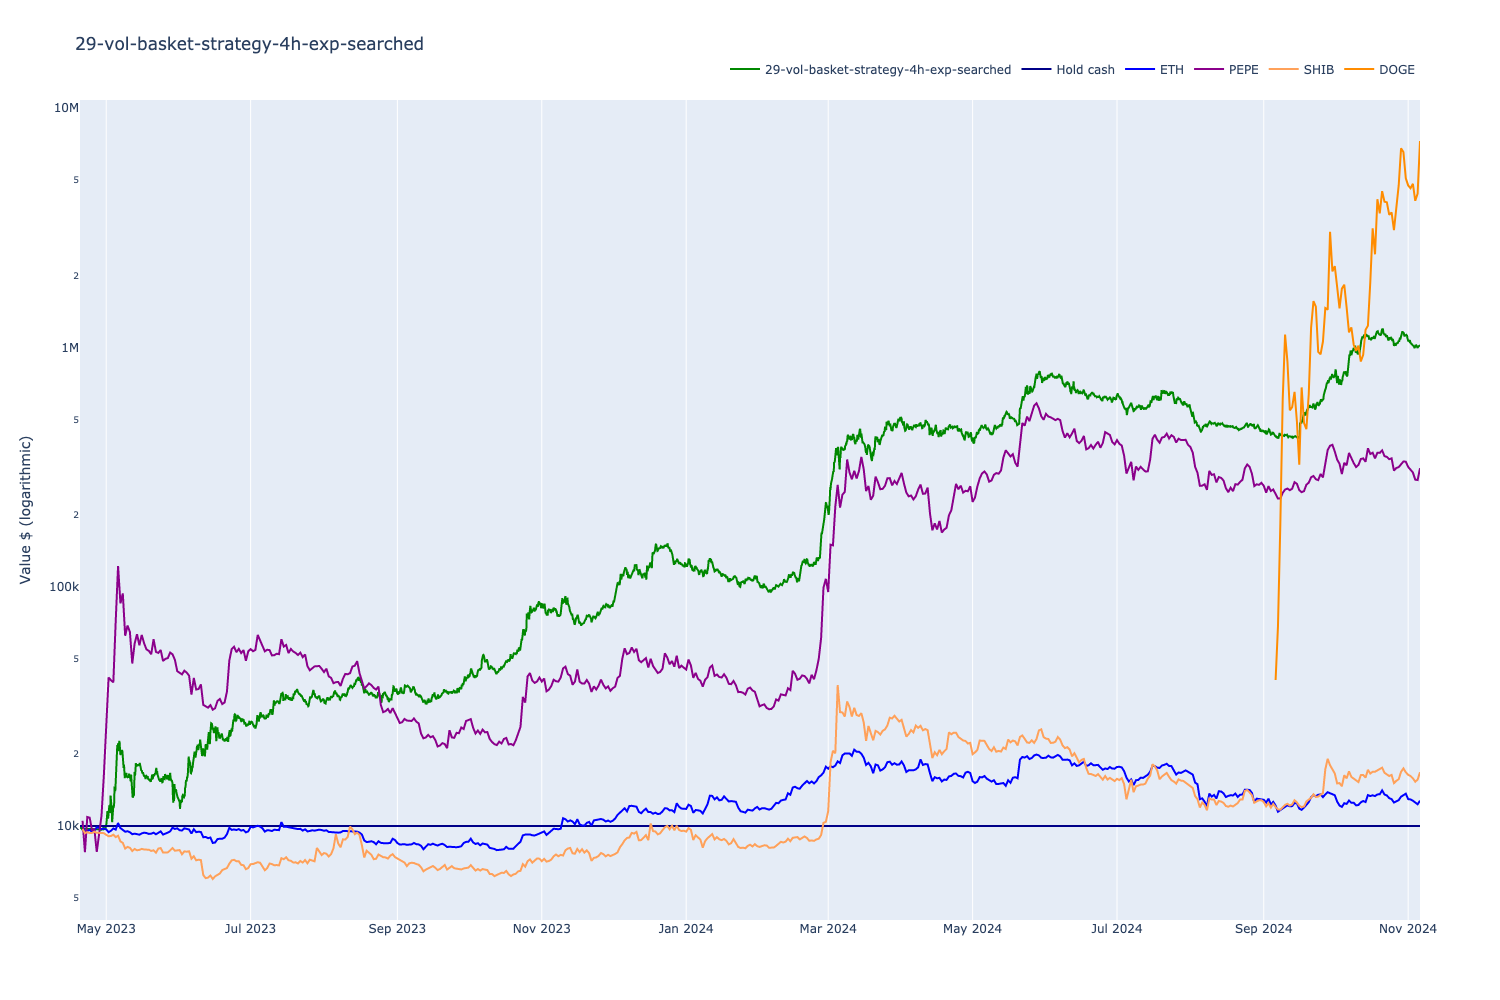

In [100]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "PEPE", "SHIB", "DOGE"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

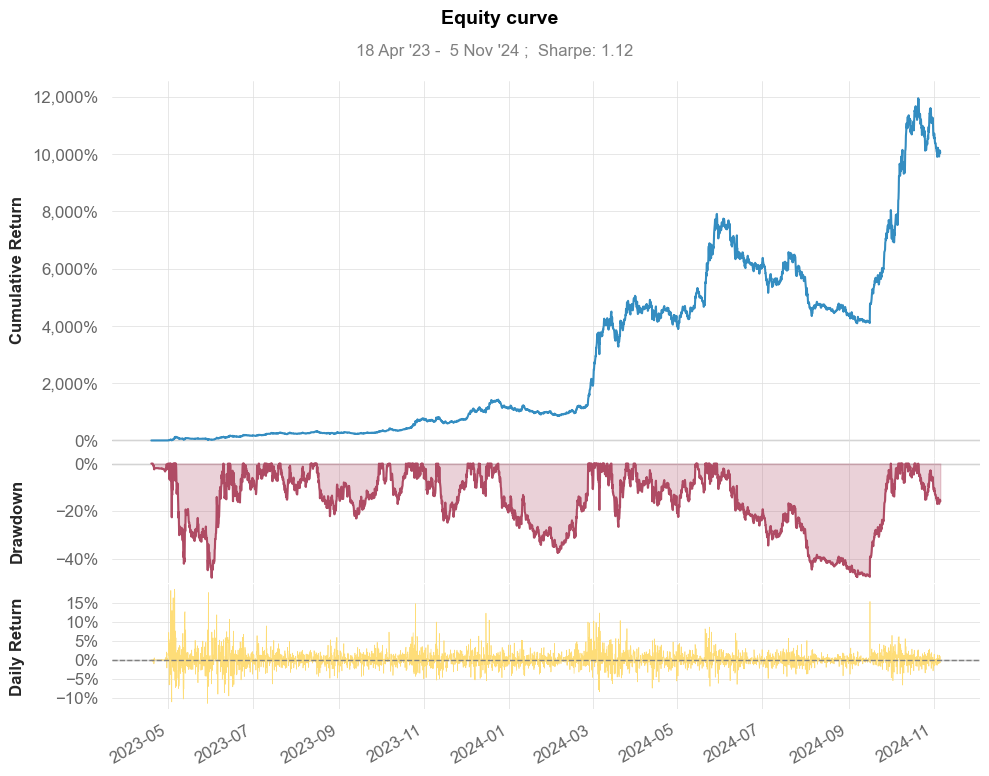

In [101]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Available pairs

- Number of pairs available to trade every month



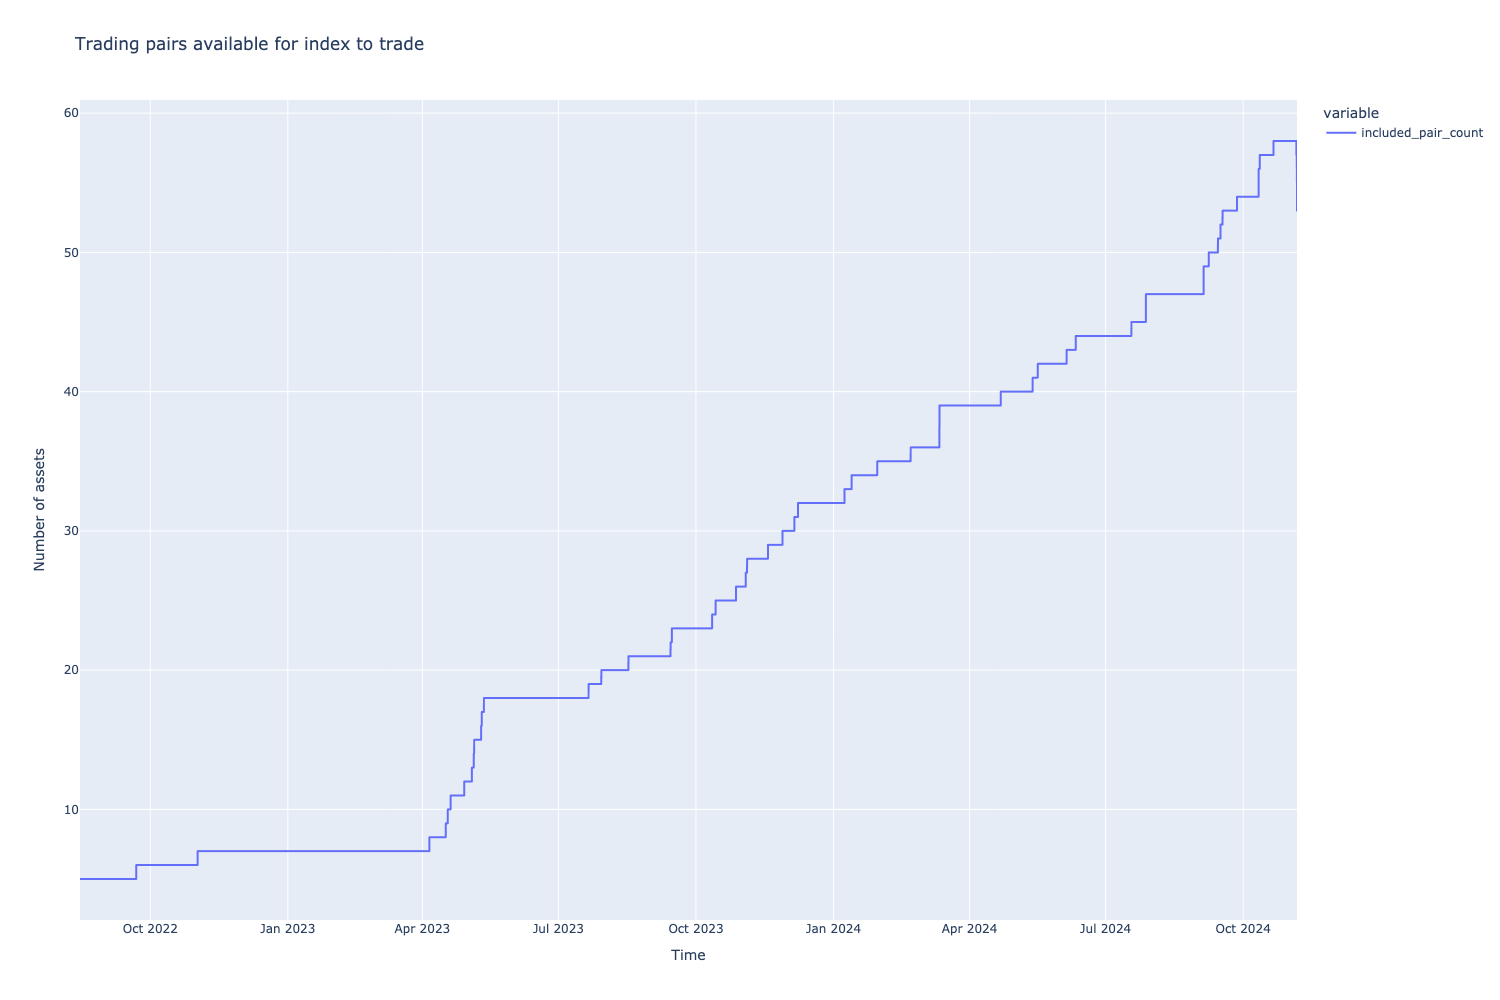

In [102]:
import plotly.express as px

df = pd.DataFrame({
    "included_pair_count": indicators.get_indicator_series("included_pair_count")
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

# Trailing sharpes



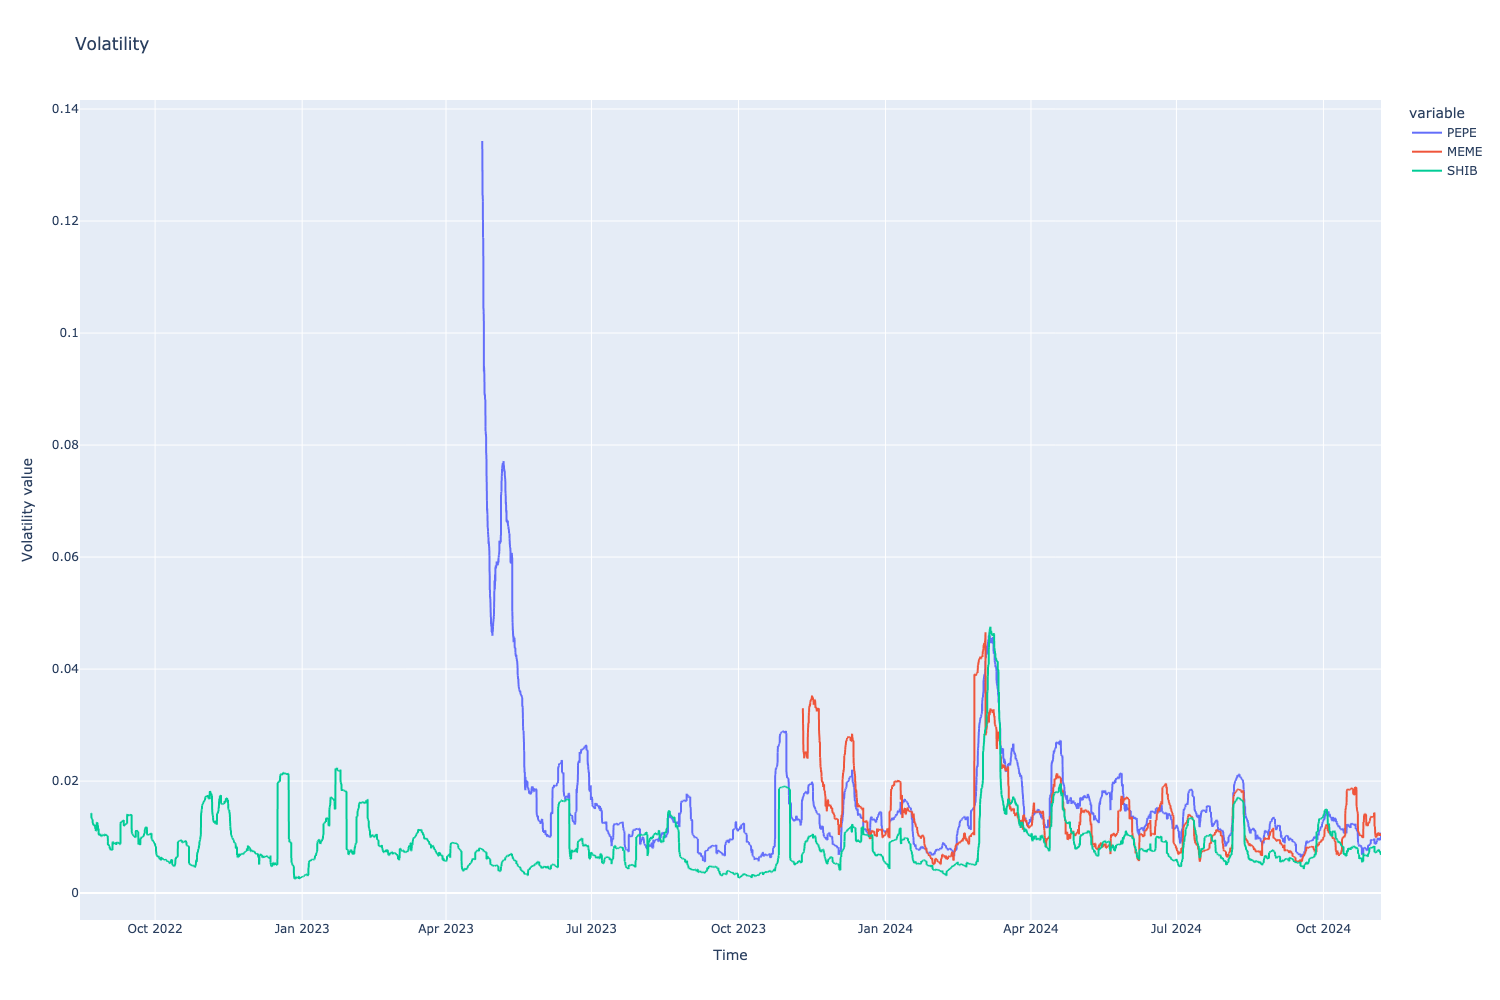

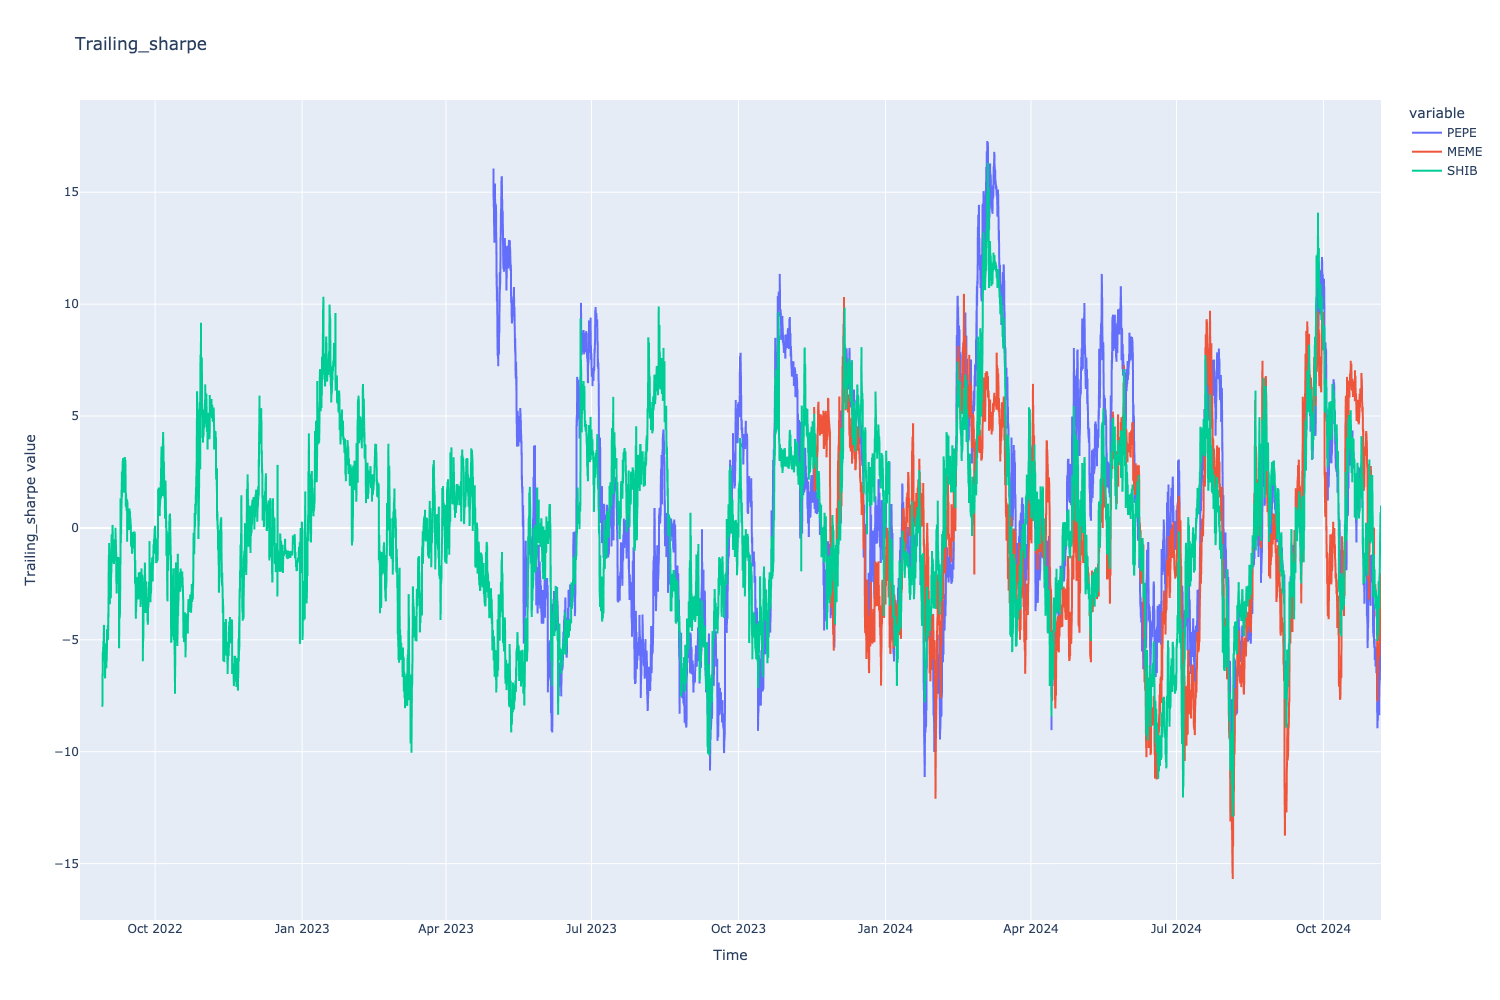

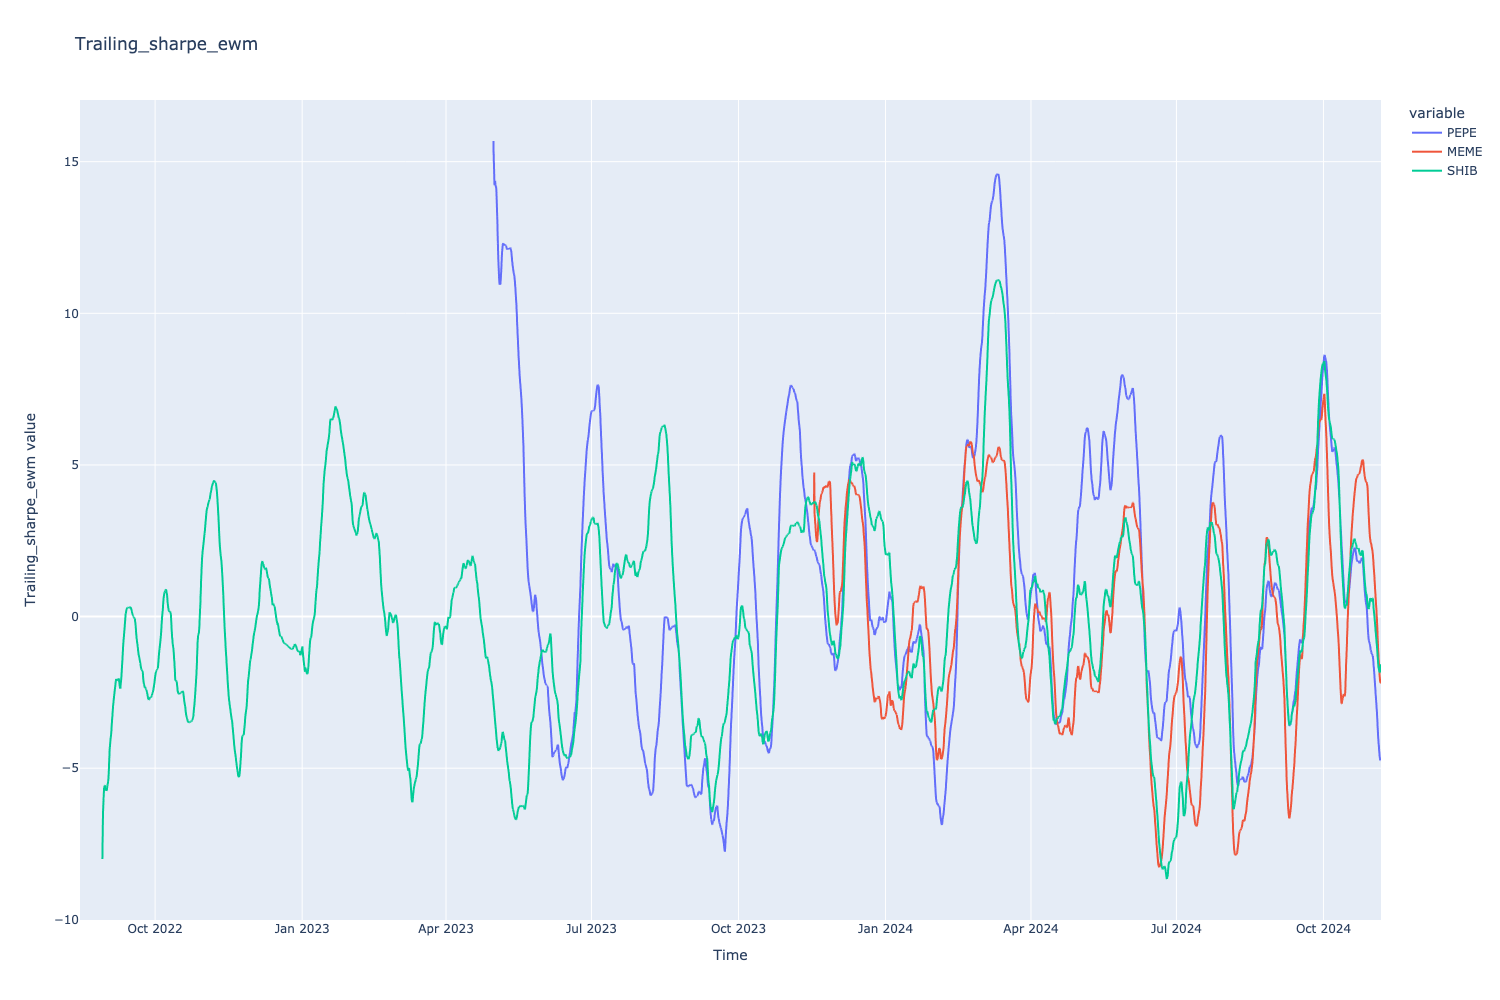

In [103]:
# Plot example indicators

import plotly.express as px

selected_assets = ["PEPE", "MEME", "SHIB"]

checked_indicators = [
    "volatility", 
    "trailing_sharpe", 
    "trailing_sharpe_ewm", 
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

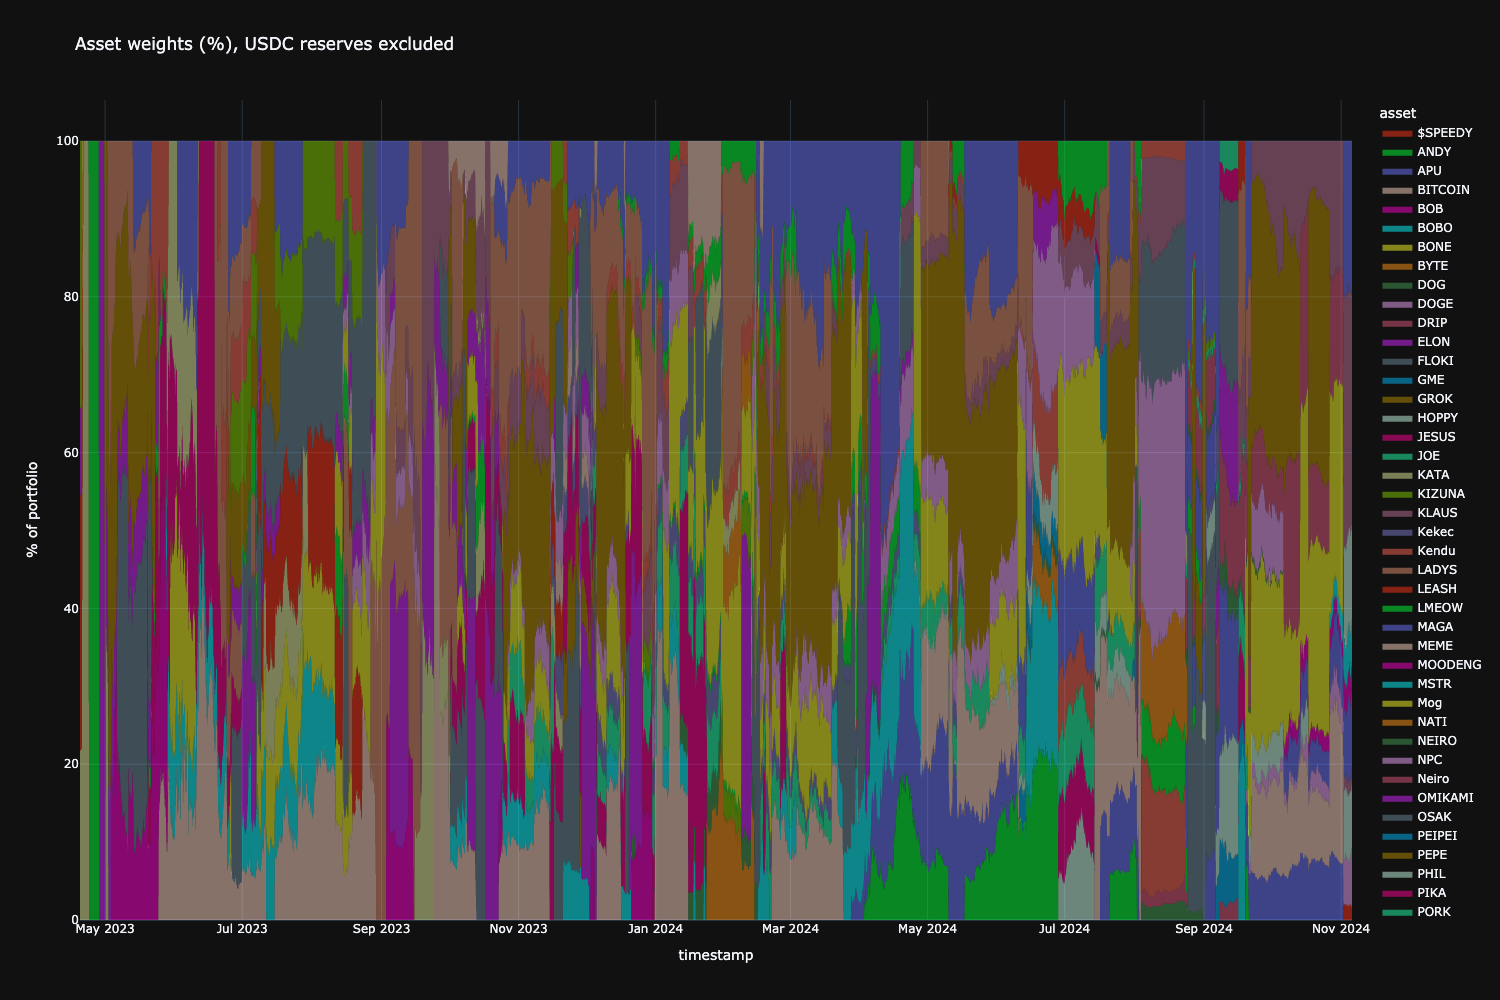

In [104]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

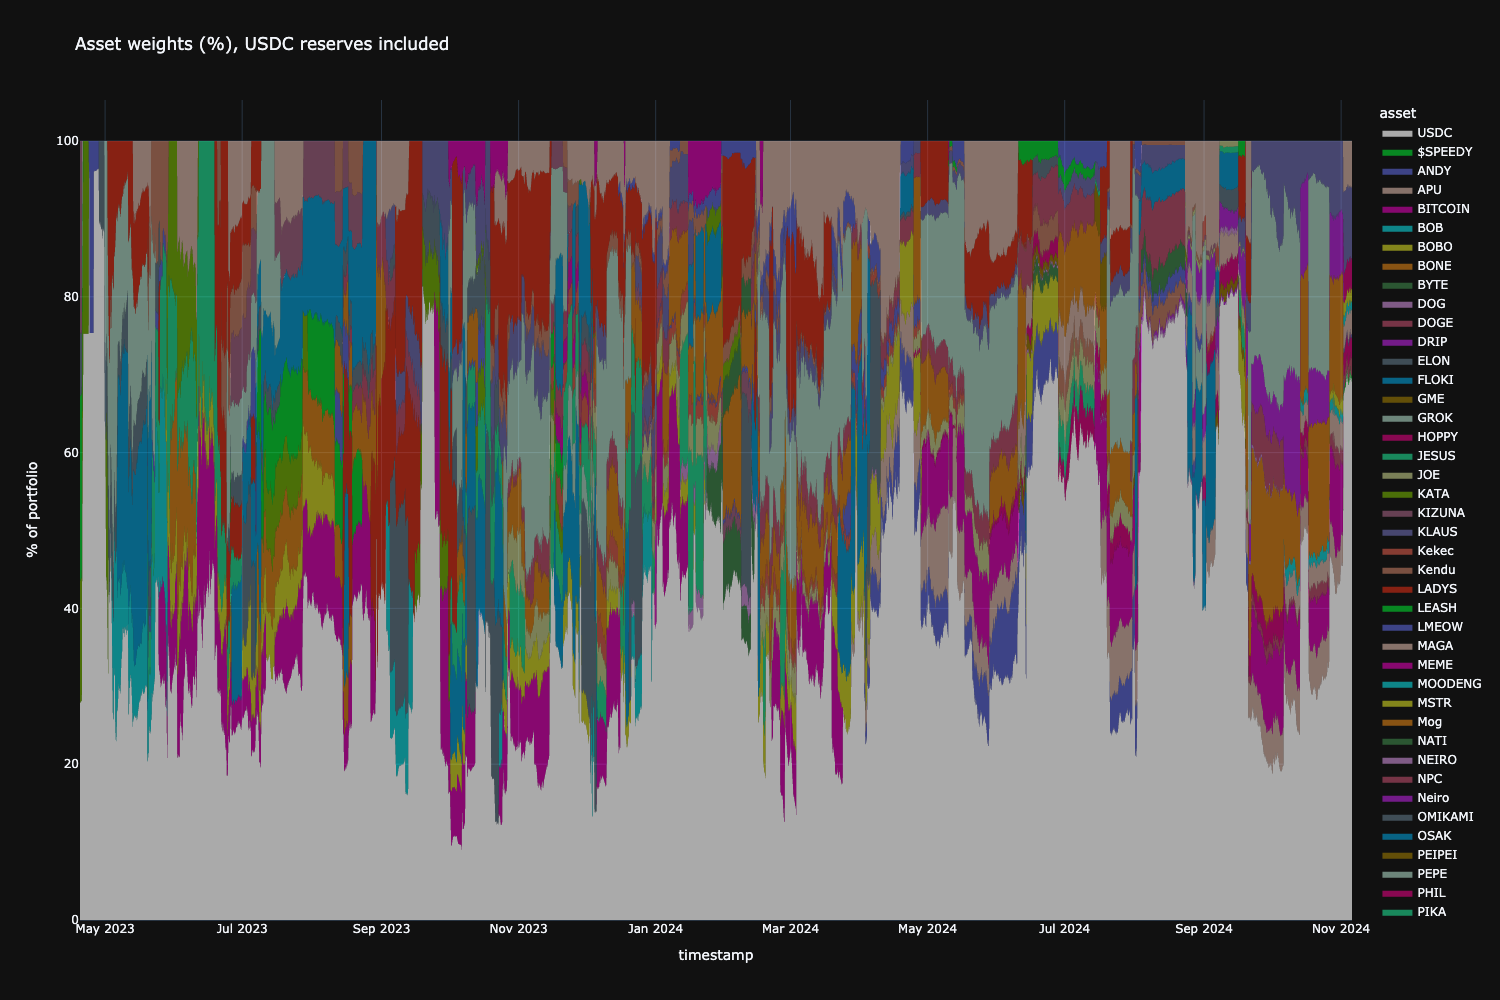

In [105]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

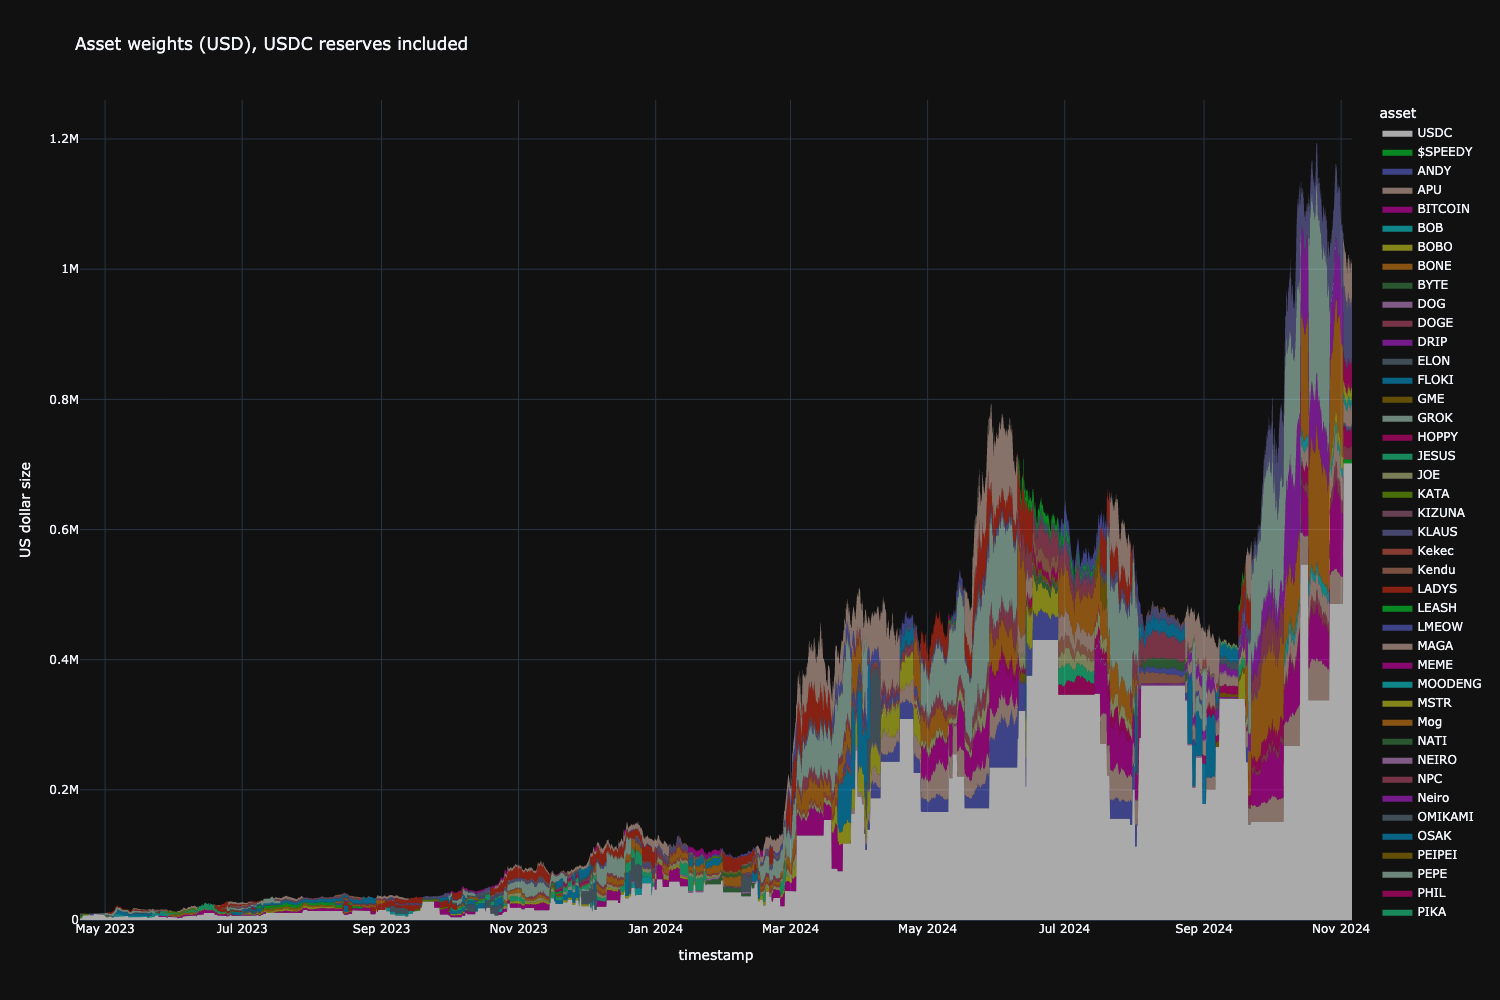

In [106]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [107]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair       Value Unit
Name                                                                       
Max position (excluding USDC)   2024-10-19 04:00:00   PEPE  293,551.24  USD
Min position (excluding USDC)   2023-10-08 08:00:00  LMEOW      275.33  USD
Mean position (excluding USDC)                               19,721.95  USD
Max position (excluding USDC)   2023-04-21 00:00:00   KATA      100.00    %
Min position (excluding USDC)   2024-10-05 04:00:00  NEIRO        0.27    %
Mean position (excluding USDC)                                   11.69    %
Max position (including USDC)   2023-04-28 04:00:00   USDC       96.55    %
Min position (including USDC)   2024-10-05 04:00:00  NEIRO        0.22    %
Mean position (including USDC)                                   10.46    %

# Trading pair breakdown

- Trade success for each trading pair



In [108]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [109]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

/Users/moo/code/trade-executor/tradeexecutor/analysis/multi_asset_benchmark.py:345: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Strategy                  BTC  \
Start Period                      2023-04-19           2023-04-19   
End Period                        2024-11-05           2024-11-05   
Risk-Free Rate                          0.0%                 0.0%   
Time in Market                        100.0%                98.0%   
Cumulative Return                 10,040.81%              135.62%   
CAGR﹪                                681.92%               46.46%   
Sharpe                                  3.24                 1.07   
Prob. Sharpe Ratio                    100.0%               92.82%   
Sortino                                 6.45                 1.89   
Sortino/√2                              4.56                 1.33   
Omega                                   1.69                  1.7   
Max Drawdown                         -45.38%              -40.76%   
Longest DD Days                          123                  236   
Gain/Pain Ratio                         0.69                 0.26   
Gain/Pain (1M)                          6.19                 2.95   
Payoff Ratio                            1.52                 1.26   
Profit Factor                           1.69                 1.26   
Common Sense Ratio                      2.99                 1.55   
CPC Index                               1.35                 0.79   
Tail Ratio                              1.77                 1.23   
Outlier Win Ratio                       4.32                 6.31   
Outlier Loss Ratio                      3.86                 4.87   
MTD                                    -6.1%               -5.71%   
3M                                    114.6%               11.63%   
6M                                   112.42%                8.98%   
YTD                                  714.97%                60.4%   
1Y                                  1197.17%               95.98%   
3Y (ann.)                            681.92%               46.46%   
5Y (ann.)                            681.92%               46.46%   
10Y (ann.)                           681.92%               46.46%   
All-time (ann.)                      681.92%               46.46%   
Avg. Drawdown                        -10.41%               -8.43%   
Avg. Drawdown Days                        13                   22   
Recovery Factor                        12.16                 3.22   
Ulcer Index                             0.18                 0.11   
Serenity Index                          5.14                  2.6   
Annualised return (raw)             6.819214                  NaN   
Benchmark start          2023-04-19 22:00:00  2023-04-19 22:00:00   
Start price                                -             29198.90   
End price                                  -             71043.09   
Price diff                                 -                 1.43   
Multiplier X                               -                 2.43   
Candle freq                                -      0 days 01:00:00   

                                         ETH  
Start Period                      2023-04-19  
End Period                        2024-11-05  
Risk-Free Rate                          0.0%  
Time in Market                        100.0%  
Cumulative Return                     23.26%  
CAGR﹪                                  9.76%  
Sharpe                                  0.52  
Prob. Sharpe Ratio                    74.17%  
Sortino                                 0.79  
Sortino/√2                              0.56  
Omega                                    1.7  
Max Drawdown                         -44.97%  
Longest DD Days                          238  
Gain/Pain Ratio                         0.08  
Gain/Pain (1M)                          0.66  
Payoff Ratio                            1.05  
Profit Factor                           1.08  
Common Sense Ratio                      1.17  
CPC Index                               0.56  
Tail Ratio                              1.08  
Outlier Win 

# Trading metrics

- Trading cost, etc.

In [110]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())